# Lab 06: Exploratory Data Analysis (EDA) with Clustering
### Author: Nigel Nelson
## Introduction:
- This lab acts as an exercise in using clustering techniques in order to aid in the exploratory data analysis of a data set comprised of emails that are labeled as spam, or ham. This data set contains 65,542 emails, all of which are stored as separate JSON files stored in a central directory. Each one of these email JSON files contains 5 features, the category describing if the email was spam or not, the email address of the recipient, the email address of the sender, the subject line of the email, and the body of the email. Students are tasked with converting this data to a Pandas DataFrame for easier manipulation. Next, this DataFrame is converted into a binary feature matrix for each email and each vocabulary word that appears in the email data set, where a 1 indicates that the email contains a given word and a 0 indicates the word is not contained in the email. Following this, a second feature matrix is created from the binary feature matrix using SVD to distill all of the information of the native emails into 10 columns/components. The two most predictive of these components are then clustered into groups by a clustering algorithm chosen from the available Scikit Learn algorithms. The calculated clusters are then visually depicted using plotting libraries to evaluate if the groups formed make logical sense given domain knowledge of the underlying data set. These clustered groups are further analyzed using a confusion matrix to determine if the calculated clusters were able to correctly distinguish spam vs. ham emails. Next, the vocabulary of the two clusters are statistically analyzed using binomial tests to determine which words appear more in one cluster than the other at a statistically significant p-value. Finally, the two clusters are analyzed by reviewing the corresponding data set entries to determine if information such as the subject line, recipient, and sender can lend more information as to what trends the clustering algorithm may be grouping by.
---
### Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import glob
import os
import json
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from scipy.sparse import csc_matrix
from scipy import stats

## Part I: Load and Transform the Data
### Loading in the Email Data Set:

In [2]:
email_dicts = []
json_dir_name = 'email_json/email_json/email_json/email_json'

json_pattern = os.path.join(json_dir_name, '*.json')
file_list = glob.glob(json_pattern)

for file in file_list:
    with open(file) as json_file:
        dict_data = json.load(json_file)
        email_dicts.append(dict_data)

### Creating an Emails DataFrame:

In [3]:
email_df = pd.DataFrame.from_dict(email_dicts)
email_df['category'] = email_df['category'].astype('category')
email_df.head()

,body,category,from_address,subject,to_address
0,\n\n\n\n\n\n\nDo you feel the pressure to perf...,spam,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca
1,"Hi, i've just updated from the gulus and I che...",ham,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,debian-mirrors@lists.debian.org
2,authentic viagra\n\nMega authenticV I A G R A...,spam,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,<the00@plg.uwaterloo.ca>
3,"\nHey Billy, \n\nit was really fun going out t...",spam,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,opt4@speedy.uwaterloo.ca
4,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",spam,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca


In [4]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
body            63542 non-null object
category        63542 non-null category
from_address    63542 non-null object
subject         63410 non-null object
to_address      63141 non-null object
dtypes: category(1), object(4)
memory usage: 2.0+ MB


### Using Scikit Learn's to Create Feature Matrix:

In [5]:
vectorizer = CountVectorizer(binary=True, min_df=10)
feat_matrix = vectorizer.fit_transform(email_df['body'])

In [6]:
print(f'Feature matrix # columns: {feat_matrix.shape[1]}')
print(f'Feature matrix # rows: {feat_matrix.shape[0]}')
print(f'Feature matrix # nonzero entries: {csr_matrix.count_nonzero(feat_matrix)}')

Feature matrix # columns: 32144
Feature matrix # rows: 63542
Feature matrix # nonzero entries: 6388795


## Part II: Cluster the Emails
### Using Scikit Learn's TruncatedSVD to Create Feature Matrix with Top 2 Variables/Components:

In [7]:
svd = TruncatedSVD(n_components=10, random_state=17)
svd_matrix = svd.fit_transform(feat_matrix)

top_components = np.vstack((svd_matrix[:,0], svd_matrix[:,1])).T
top_components.shape

(63542, 2)

### Clustering Emails Using DBSCAN:
- DBSCAN was chosen to cluster this data set for several reasons. The first is that DBSCAN is capable of clustering non-flat geometry, and uneven cluster sizes, which are important characteristics to clustering this data set after visualizing the same collection of emails in lab 5. In addition, DBSCAN is able to label data points as outliers. This is important to this data set because it is likely there are some emails that are empty, contain extremely long messages, or have other attributes that could add noise to the proper separation of spam emails from ham emails.

In [8]:
clustering = DBSCAN(eps=0.5, min_samples=10).fit(top_components)
print(f'Set of class labels produced: {set(clustering.labels_)}')

Set of class labels produced: {0, 1, -1}


In [9]:
def label_to_string(label):
    if label == -1:
        return 'Noise'
    elif label == 0:
        return 'Cluster 0'
    else:
        return 'Cluster 1'

clusters = pd.Series(clustering.labels_)
cluster_labels = clusters.apply(label_to_string)

### Plotting the Clusters Found with DBSCAN:

Text(0.5, 1.0, '2nd vs. 1st Highest Explained Variance Components')

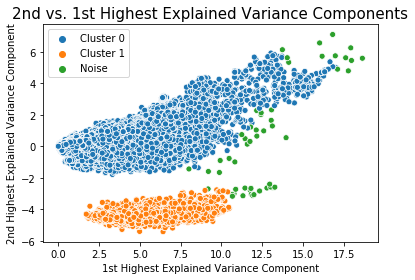

In [10]:
sns.scatterplot(x=svd_matrix[:,0], y=svd_matrix[:,1], hue=cluster_labels)
plt.ylabel('2nd Highest Explained Variance Component', fontsize=10)
plt.xlabel('1st Highest Explained Variance Component', fontsize=10)
plt.title('2nd vs. 1st Highest Explained Variance Components', fontsize=15)

### Creating Confusion Matrix for Clusters vs. Data Set Spam Labels:

In [11]:
def create_spam_labels(label):
    if label == -1:
        return 'noise'
    elif label == 0:
        return 'spam'
    else:
        return 'ham'

spam_labels = clusters.apply(create_spam_labels)

Text(0.5, 1, 'Confusion Matrix for True Labels vs. Cluster Labels')

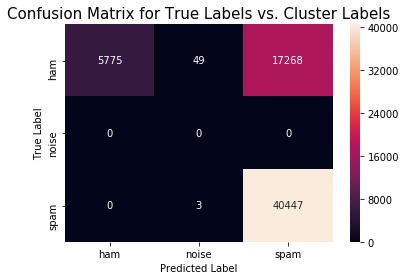

In [12]:
x = confusion_matrix(email_df['category'], spam_labels)
sns.heatmap(x, annot=True, fmt='g')
plt.yticks(np.arange(.5, 3.5, step=1), labels= ['ham', 'noise', 'spam'])
plt.xticks(np.arange(.5, 3.5, step=1), labels= ['ham', 'noise', 'spam'])
plt.ylabel('True Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix for True Labels vs. Cluster Labels', fontsize=15)

## Part III: Calculating Document Frequencies of Words

### Removing Emails that were Labeled as Noise:
- The DBSCAN clustering algorithm labeled 52 emails as noise. This means that it was unable to place these emails into one of the two clusterers, meaning it didn't share enough sinmilarity with either to be considered apart of the cluster. In order to remove bias that these outliers may introduce, these noisey data points are removed from any further analysis.

In [13]:
cleaned_df = email_df[spam_labels != 'noise']
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63490 entries, 0 to 63541
Data columns (total 5 columns):
body            63490 non-null object
category        63490 non-null category
from_address    63490 non-null object
subject         63358 non-null object
to_address      63089 non-null object
dtypes: category(1), object(4)
memory usage: 2.5+ MB


### Creating Separate Matrices for each Cluster:

In [14]:
cluster0_df = feat_matrix[(spam_labels == 'spam').values]
cluster1_df = feat_matrix[(spam_labels == 'ham').values]

### Converting the Matrices to CSC Format:

In [15]:
cluster0_matrix = csc_matrix(cluster0_df)
cluster1_matrix = csc_matrix(cluster1_df)

### Getting Document Frequency of each Word:

In [16]:
c0_doc_freq = cluster0_matrix.sum(0)
c1_doc_freq = cluster1_matrix.sum(0)

c1_doc_freq.shape

(1, 32144)

### Document Frequencies of "love", "works", and "different":

In [17]:
love_idx = vectorizer.vocabulary_.get('love')
works_idx = vectorizer.vocabulary_.get('works')
diff_idx = vectorizer.vocabulary_.get('different')

print(f'Frequency of "love" in cluster 0 emails: {c0_doc_freq[0, love_idx]}')
print(f'Frequency of "works" in cluster 0 emails: {c0_doc_freq[0, works_idx]}')
print(f'Frequency of "different" in cluster 0 emails: {c0_doc_freq[0, diff_idx]}')
print()
print(f'Frequency of "love" in cluster 1 emails: {c1_doc_freq[0, love_idx]}')
print(f'Frequency of "works" in cluster 1 emails: {c1_doc_freq[0, works_idx]}')
print(f'Frequency of "different" in cluster 1 emails: {c1_doc_freq[0, diff_idx]}')

Frequency of "love" in cluster 0 emails: 2012
Frequency of "works" in cluster 0 emails: 2361
Frequency of "different" in cluster 0 emails: 2083

Frequency of "love" in cluster 1 emails: 23
Frequency of "works" in cluster 1 emails: 628
Frequency of "different" in cluster 1 emails: 776


## Part IV: Find Enriched Words with Statistical Testing
### Testing if the Words "works" and "love" are Enriched in Cluster 1

In [18]:
cluster_0_expected_prob = c0_doc_freq[0, works_idx] / cluster0_df.shape[0]
cluster_1_expected_prob = c1_doc_freq[0, works_idx] / cluster1_df.shape[0]
pvalue = stats.binom_test(c0_doc_freq[0, works_idx], cluster0_df.shape[0],
cluster_1_expected_prob, alternative="greater")
print(f'Expected probabilty of "works" appearing in cluster 0: {cluster_0_expected_prob}')
print(f'Observed probabilty of "works" appearing in cluster 1: {cluster_1_expected_prob}')
print(f'Binomial test p-value: {pvalue}')

Expected probabilty of "works" appearing in cluster 0: 0.04090790955557481
Observed probabilty of "works" appearing in cluster 1: 0.10874458874458874
Binomial test p-value: 0.9999999999999999


- Interpretation: The observed frequency of the word "works" for cluster 0 is NOT greater than the frequency for cluster 1

In [19]:
cluster_0_expected_prob = c0_doc_freq[0, love_idx] / cluster0_df.shape[0]
cluster_1_expected_prob = c1_doc_freq[0, love_idx] / cluster1_df.shape[0]
pvalue = stats.binom_test(c0_doc_freq[0, love_idx], cluster0_df.shape[0],
cluster_1_expected_prob, alternative="greater")
print(f'Expected probabilty of "love" appearing in cluster 0: {cluster_0_expected_prob}')
print(f'Observed probabilty of "love" appearing in cluster 1: {cluster_1_expected_prob}')
print(f'Binomial test p-value: {pvalue}')

Expected probabilty of "love" appearing in cluster 0: 0.034860954691154813
Observed probabilty of "love" appearing in cluster 1: 0.003982683982683983
Binomial test p-value: 0.0


- Interpretation: The observed frequency of the word "love" for cluster 0 is greater than the frequency for cluster 1

### Iterating Over all Vocab in the Emails to Find Enriched Words for Cluster 0:
- Note: A p-value of 0.05 is used to determine if the word's frequency is statistically significant between the two clusters

In [20]:
def find_enriched_words(cluster_tested, num_emails_tested,
                        cluster_compared, num_emails_compared, word, word_idx):
    compared_expected_prob = cluster_compared[0, word_idx] / num_emails_compared
    pvalue = stats.binom_test(cluster_tested[0, word_idx], num_emails_tested,
    compared_expected_prob, alternative="greater")
    return pvalue, word, cluster_tested[0, word_idx]

In [21]:
c0_significant_vocab = []

for word, word_idx in vectorizer.vocabulary_.items():
    pvalue, word, c0_word_freq = find_enriched_words(c0_doc_freq, cluster0_df.shape[0],
                                                     c1_doc_freq, cluster1_df.shape[0],
                                                    word, word_idx)
    if pvalue < 0.05:
        c0_significant_vocab.append((pvalue, word, c0_word_freq)) 

### Filtering Out Non-Alphabetic Vocabulary:

In [22]:
print(f'Length of enriched word for cluster 0 before filtering: {len(c0_significant_vocab)}')

cleaned_c0_significant_vocab = []

for  pvalue, word, c0_word_freq in c0_significant_vocab:
    if word.isalpha():
        cleaned_c0_significant_vocab.append((pvalue, word, c0_word_freq))

print(f'Length of enriched word for cluster 0 after filtering: {len(cleaned_c0_significant_vocab)}')

Length of enriched word for cluster 0 before filtering: 23977
Length of enriched word for cluster 0 after filtering: 20300


In [23]:
cleaned_c0_significant_vocab.sort(key= lambda enriched_tuple : (enriched_tuple[0], -enriched_tuple[2]))
print(cleaned_c0_significant_vocab[:201])

[(0.0, 'your', 25822), (0.0, 'we', 17259), (0.0, 'here', 13601), (0.0, 'our', 13368), (0.0, 'up', 10841), (0.0, 'us', 9444), (0.0, 'day', 8353), (0.0, 'click', 7697), (0.0, 'their', 7415), (0.0, 'unsubscribe', 7378), (0.0, 'most', 7144), (0.0, 'price', 7069), (0.0, 'over', 6912), (0.0, 'who', 6851), (0.0, 'he', 6800), (0.0, 'online', 6781), (0.0, 'news', 5992), (0.0, 'buy', 5842), (0.0, 'said', 5574), (0.0, 'free', 5570), (0.0, 'his', 5546), (0.0, 'money', 5381), (0.0, 'visit', 5325), (0.0, 'high', 5261), (0.0, 'contact', 5235), (0.0, 'ca', 5225), (0.0, 'service', 5223), (0.0, 'life', 4832), (0.0, 'world', 4784), (0.0, 'site', 4708), (0.0, 'viagra', 4675), (0.0, 'quality', 4674), (0.0, 'low', 4404), (0.0, 'every', 4401), (0.0, 'business', 4185), (0.0, 'net', 4185), (0.0, 'men', 4128), (0.0, 'today', 4105), (0.0, 'home', 4075), (0.0, 'special', 4063), (0.0, 'her', 4005), (0.0, 'company', 3980), (0.0, 'week', 3966), (0.0, 'she', 3672), (0.0, 'great', 3642), (0.0, 'full', 3553), (0.0, 'to

### Iterating Over all Vocab in the Emails to Find Enriched Words for Cluster 1:
- Note: A p-value of 0.05 is used to determine if the word's frequency is statistically significant between the two clusters

In [24]:
c1_significant_vocab = []

for word, word_idx in vectorizer.vocabulary_.items():
    pvalue, word, c1_word_freq = find_enriched_words(c1_doc_freq, cluster1_df.shape[0],
                                                     c0_doc_freq, cluster0_df.shape[0],
                                                    word, word_idx)
    if pvalue < 0.05:
        c1_significant_vocab.append((pvalue, word, c1_word_freq)) 

### Filtering Out Non-Alphabetic Vocabulary:

In [25]:
print(f'Length of enriched word for cluster 1 before filtering: {len(c1_significant_vocab)}')

cleaned_c1_significant_vocab = []

for  pvalue, word, c1_word_freq in c1_significant_vocab:
    if word.isalpha():
        cleaned_c1_significant_vocab.append((pvalue, word, c1_word_freq))

print(f'Length of enriched word for cluster 0 after filtering: {len(cleaned_c1_significant_vocab)}')

Length of enriched word for cluster 1 before filtering: 5357
Length of enriched word for cluster 0 after filtering: 4517


In [26]:
cleaned_c1_significant_vocab.sort(key= lambda enriched_tuple : (enriched_tuple[0], -enriched_tuple[2]))
print(cleaned_c1_significant_vocab[:201])

[(0.0, 'do', 5775), (0.0, 'the', 5775), (0.0, 'self', 5775), (0.0, 'http', 5775), (0.0, 'org', 5775), (0.0, 'guide', 5775), (0.0, 'help', 5775), (0.0, 'www', 5775), (0.0, 'mailing', 5775), (0.0, 'stat', 5775), (0.0, 'math', 5775), (0.0, 'ethz', 5775), (0.0, 'ch', 5775), (0.0, 'mailman', 5775), (0.0, 'listinfo', 5775), (0.0, 'read', 5775), (0.0, 'posting', 5775), (0.0, 'project', 5775), (0.0, 'provide', 5775), (0.0, 'commented', 5775), (0.0, 'minimal', 5775), (0.0, 'contained', 5775), (0.0, 'reproducible', 5775), (0.0, 'code', 5775), (0.0, 'and', 5763), (0.0, 'list', 5718), (0.0, 'html', 5708), (0.0, 'please', 5704), (0.0, 'https', 5690), (0.0, 'to', 5380), (0.0, 'in', 4835), (0.0, 'of', 4737), (0.0, 'is', 4725), (0.0, 'this', 4086), (0.0, 'that', 3714), (0.0, 'but', 3394), (0.0, 'can', 3006), (0.0, 'wrote', 3000), (0.0, 'thanks', 2786), (0.0, 'there', 2490), (0.0, 'data', 2452), (0.0, 'am', 2208), (0.0, 'use', 2186), (0.0, 'using', 2176), (0.0, 'my', 2174), (0.0, 'how', 2163), (0.0, 'w

## Reflection Questions:
1. Make a guess as to why the emails might form two distinct clusters
  1. After skimming through the two clustered groups of email bodies, it appears that the reason for these two distinct groups is due to two different email body types, one which represents an initial email and one which represents a continuation of an email conversation. In many emails I saw, they began with a date, time, and what was last emailed in the conversation. The structure of this “reply” style email was likely picked up by the two most predictive principle components through common alpha-numeric tokens used. So, it is likely that the top, larger cluster seen in the plots represents initial emails, whereas the bottom, smaller cluster represents emails that were sent as a reply.
2. Compare the ham/spam labels to the cluster labels using the confusion matrix you generated. Are spam messages in both clusters or a single cluster? Are all of the messages in the clusters with spam labeled as spam?
  1. Spam emails are all in a single cluster. Howeveer, this cluster contains both spam and ham.
3. Skim through the top 200 words for each cluster. Can you identify any patterns for either of the clusters?
  1. One of the patterns that I noticed for the cluster containing spam is that the most common vocabulary included words that indicate requested action (“click”, “unsubscribe”, “buy”,  and “request”) or vocabulary that is associated with products (“price”, “free”, “money”, “Viagra”). However, for the cluster that contained only ham emails, the vocabulary reflected a much more technical email body (“stat”, “math”, “project”, “reproducible”, and “code”).
4. Select the rows in the DataFrames for the emails in cluster 0. Print the top 25. Do the same for cluster 1. Do you the to and from addresses and subject lines provide additional help in identifying patterns?


In [27]:
email_df[(spam_labels == 'spam').values].head(25)

,body,category,from_address,subject,to_address
0,\n\n\n\n\n\n\nDo you feel the pressure to perf...,spam,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",the00@speedy.uwaterloo.ca
1,"Hi, i've just updated from the gulus and I che...",ham,Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,debian-mirrors@lists.debian.org
2,authentic viagra\n\nMega authenticV I A G R A...,spam,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,<the00@plg.uwaterloo.ca>
3,"\nHey Billy, \n\nit was really fun going out t...",spam,"""Stormy Dempsey"" <vqucsmdfgvsg@ruraltek.com>",Nice talking with ya,opt4@speedy.uwaterloo.ca
4,"\n\n\n\n\n\n\nsystem"" of the home. It will ha...",spam,"""Christi T. Jernigan"" <dcube@totalink.net>",or trembling; stomach cramps; trouble in sleep...,ktwarwic@speedy.uwaterloo.ca
5,\n\n\n\n\n\n\nthe program and the creative abi...,spam,"""Bobby L. Fleming"" <zvyrepeated@liselebel.com>",Which is duty,manager@speedy.uwaterloo.ca
6,\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t...,spam,"""Esteban Everett"" <dbmagyrln@dbmag.com>",Theorize get inside for local esc0rts who do i...,"""Theorize"" <theorize@plg.uwaterloo.ca>"
7,\n\n\n\n\n\n HoodiaLife - Start Losing Weight ...,spam,Real Loss <fibond@terra.com.do>,Losing Weight Quickly,theorize@plg.uwaterloo.ca
9,\n\n\n\n\n\n\nGood day!\nVisit our new online ...,spam,"""Billy Chin"" <boxer@0733.com>",For Smile,<smile@speedy.uwaterloo.ca>
10,\nCheck out the wonders of pound melting\n\n\n...,spam,"""Josie Abernathy"" <cebcalhounrennerhog@calhoun...",Less weight - more pleasure and joy,ftp@plg.uwaterloo.ca


In [28]:
email_df[(spam_labels == 'ham').values].head(25)

,body,category,from_address,subject,to_address
8,\nHi...\n\nI have to use R to find out the 90%...,ham,"""Jochen.F"" <jjfahr@ucalgary.ca>",[R] Confidence-Intervals.... help...,r-help@stat.math.ethz.ch
16,Hm... sounds like a homework problem to me...\...,ham,"""Sarah Goslee"" <sarah.goslee@gmail.com>",Re: [R] Confidence-Intervals.... help...,"""Jochen.F"" <jjfahr@ucalgary.ca>"
24,"Daer r-helpers,\n\nCan anyone help with the fo...",ham,Michael Kubovy <kubovy@virginia.edu>,[R] Failure of mcsamp() but not mcmcsamp(),r-help@stat.math.ethz.ch
68,"On 4/6/07, Wilfred Zegwaard wrote:\n\n> I'm n...",ham,"""Johann Hibschman"" <johannh@gmail.com>",Re: [R] Reasons to Use R,"""Wilfred Zegwaard"" <wilfred.zegwaard@gmail.com>"
75,"On 4/8/07, Johann Hibschman wrote:\n> R's pas...",ham,"""Gabor Grothendieck"" <ggrothendieck@gmail.com>",Re: [R] Reasons to Use R,"""Johann Hibschman"" <johannh@gmail.com>"
112,I have a question to everybody.\n\nAfter log10...,ham,"""Zia Uddin Ahmed"" <zua3@cornell.edu>",[R] How do I back transforme ordinary log-krig...,r-help@stat.math.ethz.ch
149,\nI am writing some code to obtain publication...,ham,"""Cressoni, Massimo \(NIH/NHLBI\) [F]"" <cresson...",[R] Plot symbols dimensions,<r-help@stat.math.ethz.ch>
278,"Dear Johann and Gabor,\n\nIt's what amounts to...",ham,Wilfred Zegwaard <wilfred.zegwaard@gmail.com>,Re: [R] Reasons to Use R,r-help@stat.math.ethz.ch
307,"Dear R-users,\n\nI would like to use ""bruto"" f...",ham,=?ISO-2022-JP?B?GyRCQG44fRsoQiAbJEI9JDwjGyhC?=...,[R] Could not fit correct values in discrimina...,r-help@stat.math.ethz.ch
318,"Dear R users,\n\nI am new to R. I would like t...",ham,"""joey repice"" <fireseedmusic@gmail.com>",[R] R:Maximum likelihood estimation using BHHH...,r-help@stat.math.ethz.ch


4. -
  1. By comparing email entries from both of the clusters, two attributes appear to separate the two groups. The first is that the subject lines for cluster 1, the smaller cluster that appears lower on the cluster plots, contain some indication that the emails were reply emails. This is indicated in the subject lines by the prefix “Re:”. Second, cluster 1 appears to have many more “common” email domains for the individual that sent the email than in cluster 1. This was observed because cluster 1 has several senders with “@gmail.com” and “.edu” email domains compared to cluster 0 which primarily has suspicious domains such as “@0733.com” and “@funeasy.biz”.
5. The clusters represent email from two separate mailing lists. One mailing list is for the R programming language, while the other mailing list is for a university. Which mailing list contained all of the spam?
  1. As mentioned earlier, cluster 1 contained many more technical terms such as “stat”, “math”, “project”, “reproducible”, and “code”. All of these terms are common when discussing programming languages, as such, it appears that cluster 1 was the R programming language mailing list. This conclusion is further supported by the fact that many of the subject lines contain references to 'R' and phrases such as 'Reasons to Use R', which are extremely likely to be references to the R progamming language. In addition, just about all of email recipients for cluster 0 had the domain “uwaterloo.ca”, further indicating that cluster 0 was likely the university mailing list.

---
## Conclusion:
- This lab acted as an exercise in using clustering techniques in order to aid in the exploratory data analysis of a data set comprised of emails that are labeled as spam, or ham. This data set contains 65,542 emails, all of which are stored as separate JSON files stored in a central directory. In order to find the most accurate clusters that could be found using this data set, the DBSCAN algorithm was used from Scikit Learn due to its ability to cluster non-flat geometry, uneven clusters, and label data points as outliers. Using the body of the emails, DBSCAN was able to find two clusters within the data, and labeled 52 emails as outliers. These groups somewhat corresponded to whether the emails were spam or ham, as every email in cluster 1 was ham, but emails in cluster 0 were roughly 2/3 spam and 1/3 ham. By analyzing the vocabulary for statistically significant differences in word frequencies it was found that most of the spam emails contained vocabulary associated with action, “click”, “unsubscribe”, “buy”, and “request”, as well as products, “price”, “free”, “money”, “Viagra”. Whereas the ham emails contained vocabulary that was much more technical, “stat”, “math”, “project”, “reproducible”, and “code”. Lastly, after learning that this data set was comprised of a mailing list for the R programming language and a university mailing list, it became clear that this was likely the two groups that DBSCAN was clustering by. This was made apparent by observing that cluster 0 all had recipient domains of “uwaterloo.ca”, and that cluster 1 had subject lines containing indications of active replies to emails indicated by the “Re:” prefix and also the fact that the subject lines contained many uses of ‘R’, which is almost positively a reference to the R programming language.